In [2]:
import os, sys

import pathlib
import pandas as pd
import numpy as np
from easydict import EasyDict as edict
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import time


In [3]:
dir_path = pathlib.Path().absolute()
file = '../data/imputed_data.csv'
data_path = os.path.join(dir_path, file)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_csv(data_path  ,index_col=False).drop(['Unnamed: 0'], axis=1)
df.reset_index(drop=True, inplace=True)
assert df.isnull().sum().sum() == 0

df.drop(columns=['SPI_X1','SPI_Y1','SPI_X2','SPI_Y2','SPI_L1','SPI_W1','SPI_L2','SPI_W2'], inplace=True)
df.head(10)

,CRD,PartType,Orient.,X,Y,SPI_X_AVG,SPI_Y_AVG,SPI_L,SPI_W,PRE_X,PRE_Y,PRE_A,PRE_L,PRE_W,POST_X,POST_Y,POST_A,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_VOLUME_MEAN
0,B1,R0402,90.0,31.26,100.11,-52.00,61.90,61.90,52.00,-19.887293,-1.840963,-1.877,-1.840963,19.887293,-7.440417,28.108231,1.613,28.108231,7.440417,CENTER,400.0,200.0,78.71525
1,B2,R0402,90.0,31.83,100.11,-47.00,63.70,63.70,47.00,-26.766272,6.898049,-1.449,6.898049,26.766272,5.487133,22.242701,0.000,22.242701,-5.487133,CENTER,400.0,200.0,77.33190
2,B3,R0402,90.0,32.40,100.11,-41.60,72.35,72.35,41.60,-32.058273,8.125244,-3.278,8.125244,32.058273,-19.644203,12.971593,1.552,12.971593,19.644203,CENTER,400.0,200.0,77.17380
3,B4,R0402,90.0,32.97,100.11,-50.60,63.10,63.10,50.60,-23.437572,-6.195457,-3.337,-6.195457,23.437572,-22.517658,26.396389,0.000,26.396389,22.517658,CENTER,400.0,200.0,77.96495
4,B5,R0402,90.0,33.54,100.11,-50.00,69.45,69.45,50.00,-5.187286,7.085744,-3.408,7.085744,5.187286,-21.413681,29.193306,3.611,29.193306,21.413681,CENTER,400.0,200.0,75.37700
5,B6,R0402,90.0,31.26,99.20,-49.10,59.75,59.75,49.10,-31.059980,1.531298,3.611,1.531298,31.059980,-5.925862,17.682121,0.000,17.682121,5.925862,CENTER,400.0,200.0,77.66230
6,B7,R0402,90.0,31.83,99.20,-44.95,60.10,60.10,44.95,-20.728939,10.258562,-3.247,10.258562,20.728939,-17.024027,33.615910,3.455,33.615910,17.024027,CENTER,400.0,200.0,77.56575
7,B8,R0402,90.0,32.40,99.20,-39.05,70.00,70.00,39.05,-27.195978,11.357373,-2.031,11.357373,27.195978,-1.401807,29.627155,3.337,29.627155,1.401807,CENTER,400.0,200.0,79.10090
8,B9,R0402,90.0,32.97,99.20,-46.55,62.45,62.45,46.55,-19.822590,1.057152,-3.047,1.057152,19.822590,-20.989681,15.195607,3.310,15.195607,20.989681,CENTER,400.0,200.0,81.96445
9,B10,R0402,90.0,33.54,99.20,-53.25,71.15,71.15,53.25,-26.842043,3.604794,-3.022,3.604794,26.842043,-17.169552,31.046926,-1.660,31.046926,17.169552,CENTER,400.0,200.0,79.36680


In [4]:
# switch 90 data to 0 data
def switchOrient(x90, y90):
    y0 = float(x90)
    x0 = float(-y90)
    return x0, y0 

In [5]:
ABSOLUTE_ANGLE = True
BY_CHIP_PERCENTAGE = True
PRE_OR_POST_ANGLE = 'pre'
DISTANCE = 'spi' # [DISTANCE] - POST 
STOP_AFTER = 10 # rows

dfgroups = df.groupby(['PartType']) 

filtering criteria
1. group by chip
2. compare pre and post angles in absolute scale

In [6]:
start = time.time()

pre = edict()
post = edict()

pre_angles_low = edict()
pre_angles_high = edict()
post_angles_low = edict()
post_angles_high = edict()

for i, (chiptype, group) in enumerate(dfgroups):
    print(chiptype,'...')
    
    pre[f'{chiptype}'] = []
    post[f'{chiptype}'] = []
    
    pre_angles_low[f'{chiptype}'] = []
    pre_angles_high[f'{chiptype}'] = []
    post_angles_low[f'{chiptype}'] = []
    post_angles_high[f'{chiptype}'] = []
    
    if ABSOLUTE_ANGLE == True:
        group['PRE_A'] = group['PRE_A'].abs()
        group['POST_A'] = group['POST_A'].abs()

    t = tqdm(group.iterrows(), total=len(group))
    for idx, row in t:
        t.set_description(f'Row: {idx}')
        
        pre_angle, post_angle = row[['PRE_A','POST_A']]
        
        pre[f'{chiptype}'].append(pre_angle)
        post[f'{chiptype}'].append(post_angle)
        
        if post_angle >= pre_angle:
            pre_angles_high[chiptype].append(pre_angle)
            post_angles_high[chiptype].append(post_angle)
        elif post_angle < pre_angle:
            pre_angles_low[chiptype].append(pre_angle)
            post_angles_low[chiptype].append(post_angle)
        
    print(f'{chiptype}: post>=pre angles (post,pre): {len(post_angles_high[chiptype])},{len(pre_angles_high[chiptype])}')
    print(f'{chiptype}: post<pre angles (post,pre): {len(post_angles_low[chiptype])},{len(pre_angles_low[chiptype])}')
    
    
print(f'It took {time.time() - start} seconds')

Row: 164:   0%|          | 60/60750 [00:00<01:41, 598.10it/s]

R0402 ...


Row: 11258:   6%|▌         | 3700/60750 [00:03<00:56, 1015.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Row: 27225:  15%|█▌        | 9206/60750 [00:09<00:49, 1032.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Row: 38465:  21%|██        | 12882/60750 [00:13<00:50, 939.88it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit

R0402: post>=pre angles (post,pre): 35097,35097
R0402: post<pre angles (post,pre): 25653,25653
R0603 ...


Row: 3628:   2%|▏         | 1359/60750 [00:01<00:54, 1081.05it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Row: 14824:   8%|▊         | 5000/60750 [00:04<00:53, 1045.94it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Row: 26112:  14%|█▍        | 8777/60750 [00:08<00:49, 1042.26it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, 

R0603: post>=pre angles (post,pre): 39080,39080
R0603: post<pre angles (post,pre): 21670,21670
R1005 ...


Row: 10993:   6%|▌         | 3481/60750 [00:03<00:55, 1024.11it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Row: 24693:  13%|█▎        | 8168/60750 [00:08<00:52, 1011.10it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Row: 42546:  23%|██▎       | 13999/60750 [00:14<00:49, 940.79it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit

R1005: post>=pre angles (post,pre): 34492,34492
R1005: post<pre angles (post,pre): 26258,26258
It took 184.06968188285828 seconds


In [7]:
img_path = './reflowoven_angle'
if not os.path.exists(img_path):
    os.makedirs(img_path)

In [8]:
# save
import pickle5 as pickle
with open(f'{img_path}/pre_angles_high.p', 'wb') as fp:
    pickle.dump(pre_angles_high, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{img_path}/post_angles_high.p', 'wb') as fp:
    pickle.dump(post_angles_high, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f'{img_path}/pre_angles_low.p', 'wb') as fp:
    pickle.dump(pre_angles_low, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{img_path}/post_angles_low.p', 'wb') as fp:
    pickle.dump(post_angles_low, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{img_path}/pre.p', 'wb') as fp:
    pickle.dump(pre, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{img_path}/post.p', 'wb') as fp:
    pickle.dump(post, fp, protocol=pickle.HIGHEST_PROTOCOL)


In [39]:
# load pickle
import pickle5 as pickle
pre_angles_high = pickle.load(open(f'{img_path}/pre_angles_high.p', 'rb'))
post_angles_high = pickle.load(open(f'{img_path}/post_angles_high.p', 'rb'))

pre_angles_low = pickle.load(open(f'{img_path}/pre_angles_low.p', 'rb'))
post_angles_low = pickle.load(open(f'{img_path}/post_angles_low.p', 'rb'))

pre = pickle.load(open(f'{img_path}/pre.p', 'rb'))
post = pickle.load(open(f'{img_path}/post.p', 'rb'))


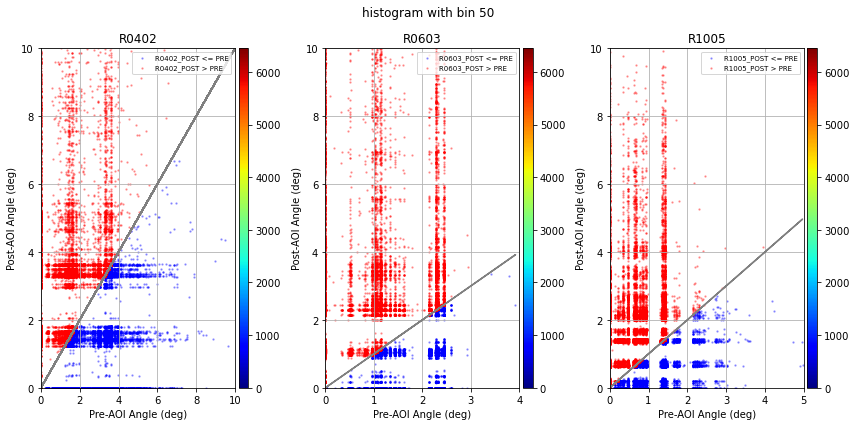

In [76]:
# visualize
chips = ['R0402','R0603','R1005']

import warnings
warnings.filterwarnings("ignore")
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,6))
# fig = plt.figure(figsize=(9,4))
histogram_bin_size = 50
ax = {}
for i, chip in enumerate(chips):
    ax[i] = fig.add_subplot(1, len(chips), i+1)
    
    ax[i].scatter(pre_angles_low[chip], post_angles_low[chip], s=2, alpha=0.3, color='b', label=f'{chip}_POST <= PRE')
    ax[i].scatter(pre_angles_high[chip], post_angles_high[chip], s=2, alpha=0.3, color='r', label=f'{chip}_POST > PRE')
    ax[i].plot(pre[chip], pre[chip], 'k-', color='gray')
    
    # 2d histogram
#     heatmap, xedges, yedges = np.histogram2d(pre[chip], \
#                                              post[chip], \
#                                              bins=histogram_bin_size)
#     extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
#     img = ax[i].imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.jet) #cmap=cm.PuBu_r)
        
    ax[i].set_title(f'{chip}')
    ax[i].legend(f'{chip}', loc='best')
    ax[i].set_xlabel('Pre-AOI Angle (deg)')
    ax[i].set_ylabel('Post-AOI Angle (deg)')
    if i == 0:
        ax[i].set_ylim([0, 10])
        ax[i].set_xlim([0, 10])
    elif i == 1:
        ax[i].set_ylim([0, 10])
        ax[i].set_xlim([0, 4])
    else:
        ax[i].set_ylim([0, 10])
        ax[i].set_xlim([0, 5])
    ax[i].legend(loc='upper right', fontsize=7)
    ax[i].grid()
    
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)    
    fig.colorbar(img, ax=ax[i], cax=cax)

fig.suptitle(f'histogram with bin {histogram_bin_size}', fontsize=12)
fig.tight_layout()
fig.savefig(f'./{img_path}/reflowoven_angles.png')
    